In [1]:
#%pip install matplotlib
#%pip install imageio

In [2]:
import IPython
import os
import json

import torch

from core.schemas import Config

from scripts.generate import *

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio

from tqdm.notebook import tqdm

%matplotlib notebook

In [3]:
MYPATH = './samples/freddieart/'
CONFIG_FILE = './configs/local.json'
DEVICE = torch.device(os.environ.get("DEVICE", 'cuda' if torch.cuda.is_available() else 'cpu')) #'cpu'
def cap_space(text):
    new_text = ''
    for i, letter in enumerate(text):
        if i and letter.isupper():
            new_text += ' '
        new_text += letter
    return new_text

In [4]:
# clean text file names
image_files = [f for f in os.listdir(MYPATH) if os.path.isfile(os.path.join(MYPATH, f))]

In [5]:
cleaned_file_names = []
for file_name in image_files:
    #remove parens
    file_name = file_name.replace('(', ' ')
    file_name = file_name.replace(')', ' ')
    
    if '+' in file_name:
        #replace + with space
        file_name = file_name.replace('+', ' ')
    elif '_' in file_name:
        file_name = file_name.replace('_', ' ')
    elif ' ' in file_name:
        pass
    else:
        #in files without white space, add space in front of capital letters
        file_name = cap_space(file_name)
    file_name = file_name.replace('  ', ' ')
    file_name = file_name.replace('.jpg', '')
    file_name = file_name.rstrip().lstrip()
    cleaned_file_names.append(file_name)
    

In [6]:
with open(CONFIG_FILE, 'r') as f:
    PARAMS = Config(**json.load(f))
model = load_vqgan_model(PARAMS.vqgan_config, PARAMS.vqgan_checkpoint, PARAMS.models_dir).to(DEVICE)
perceptor = clip.load(PARAMS.clip_model, device=DEVICE, root=PARAMS.models_dir)[0].eval().requires_grad_(False).to(DEVICE)
cut_size = perceptor.visual.input_resolution
make_cutouts = MakeCutouts(PARAMS.augments, cut_size, PARAMS.cutn, cut_pow=PARAMS.cut_pow)

z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

Saving outputs in './outputs'
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Loaded pretrained VGG16 model from './models/vgg16-397923af.pth'
Loaded pretrained LPIPS loss from './models/vgg.pth'
VQLPIPSWithDiscriminator running with hinge loss.
Restored from ./models/vqgan_imagenet_f16_16384.ckpt
Augmentations: [RandomAffine(degrees=15, translate=0.1, scale=None, shear=15, resample=BILINEAR, p=0.5, p_batch=1.0, same_on_batch=False, return_transform=False), RandomPerspective(distortion_scale=0.5, interpolation=BILINEAR, align_corners=False, p=0.5, p_batch=1.0, same_on_batch=False, return_transform=False), ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.5, p_batch=1.0, same_on_batch=False, return_transform=False), RandomErasing(scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0.0, p=0.5, p_batch=1.0, same_on_batch=False, return_transform=False)]


In [7]:
def initialize_params(prompt='a painting', init_image_path='', max_iterations=100):
    #print(f"Loading default configuration from '{CONFIG_FILE}'")
    with open(CONFIG_FILE, 'r') as f:
        PARAMS = Config(**json.load(f))
    PARAMS.prompts = [prompt]
    PARAMS.init_noise = 'fractal'
    PARAMS.init_image = init_image_path
    #print(f"Running on {DEVICE}.")
    #print(PARAMS)

    global_seed(PARAMS.seed)

    z = initialize_image(model, PARAMS)
    z_orig = torch.zeros_like(z)
    z.requires_grad_(True)
    
    PARAMS.max_iterations = max_iterations

    prompts = tokenize(model, perceptor, make_cutouts, PARAMS)
    optimizer = get_optimizer(z, PARAMS.optimizer, PARAMS.step_size)
    scheduler = get_scheduler(optimizer, PARAMS.max_iterations, PARAMS.nwarm_restarts)

    kwargs = {
        'model': model,
        'perceptor': perceptor,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'prompts': prompts,
        'make_cutouts': make_cutouts,
        'z_orig': z_orig,
        'z_min': z_min,
        'z_max': z_max,
        'mse_weight': PARAMS.init_weight,
    }
    return PARAMS, kwargs, z

<IPython.core.display.Javascript object>


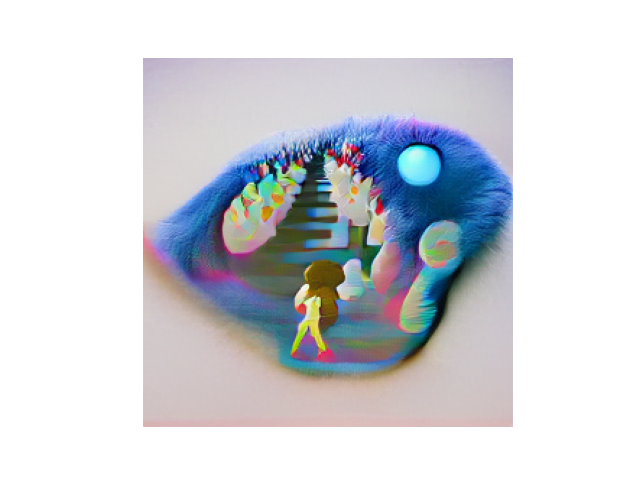

Saving outputs in './outputs'
Global seed set to 1461297086.
prompt: ['Tall Hill', 'Tall Hill'], init_file: ./samples/freddieart/Tall+Hill.jpg


/opt/conda/lib/python3.7/site-packages/kornia/utils/helpers.py:96: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  out1, out2 = torch.solve(input.to(dtype), A.to(dtype))


step: 50, loss: 1.52195, losses: 0.760975, 0.760975
step: 100, loss: 1.45226, losses: 0.726132, 0.726132
Saving outputs in './outputs'
Global seed set to 1217814432.
prompt: ['It appeared to me in the window light', 'It appeared to me in the window light'], init_file: ./samples/freddieart/It appeared to me in the window light.jpg
step: 50, loss: 1.47341, losses: 0.736707, 0.736707
step: 100, loss: 1.46058, losses: 0.73029, 0.73029
Saving outputs in './outputs'
Global seed set to 3648040426.
prompt: ['Amphibious Peradam Efflorescence', 'Amphibious Peradam Efflorescence'], init_file: ./samples/freddieart/Amphibious Peradam Efflorescence.jpg
step: 50, loss: 1.44605, losses: 0.723026, 0.723026
step: 100, loss: 1.40518, losses: 0.702591, 0.702591
Saving outputs in './outputs'
Global seed set to 3771560985.
prompt: ['Birdsong Harp', 'Birdsong Harp'], init_file: ./samples/freddieart/Birdsong Harp.jpg
step: 50, loss: 1.38177, losses: 0.690885, 0.690885
step: 100, loss: 1.38394, losses: 0.69196

step: 50, loss: 1.47886, losses: 0.739431, 0.739431
step: 100, loss: 1.42642, losses: 0.71321, 0.71321
Saving outputs in './outputs'
Global seed set to 689132400.
prompt: ['Forager Drum', 'Forager Drum'], init_file: ./samples/freddieart/Forager Drum.jpg
step: 50, loss: 1.45836, losses: 0.729181, 0.729181
step: 100, loss: 1.38535, losses: 0.692674, 0.692674
Saving outputs in './outputs'
Global seed set to 4171620723.
prompt: ['Sky Colony', 'Sky Colony'], init_file: ./samples/freddieart/Sky+Colony.jpg
step: 50, loss: 1.47369, losses: 0.736845, 0.736845
step: 100, loss: 1.44384, losses: 0.721921, 0.721921
Saving outputs in './outputs'
Global seed set to 3955301006.
prompt: ['Finding a collection of memories in outer space', 'Finding a collection of memories in outer space'], init_file: ./samples/freddieart/Finding+a+collection+of+memories+in+outer+space.jpg
step: 50, loss: 1.52218, losses: 0.761092, 0.761092
step: 100, loss: 1.4726, losses: 0.736301, 0.736301
Saving outputs in './outputs'

Saving outputs in './outputs'
Global seed set to 4239168737.
prompt: ['Ocarina for Navigating Infinite Expanses', 'Ocarina for Navigating Infinite Expanses'], init_file: ./samples/freddieart/Ocarina for Navigating Infinite Expanses.jpg
step: 50, loss: 1.3677, losses: 0.683848, 0.683848
step: 100, loss: 1.32226, losses: 0.66113, 0.66113
Saving outputs in './outputs'
Global seed set to 149261886.
prompt: ['Living Portal to Wordless Nature Memory', 'Living Portal to Wordless Nature Memory'], init_file: ./samples/freddieart/Living Portal to Wordless Nature Memory.jpg
step: 50, loss: 1.58703, losses: 0.793515, 0.793515
step: 100, loss: 1.56164, losses: 0.780818, 0.780818
Saving outputs in './outputs'
Global seed set to 4294721363.
prompt: ['Searching for brief moment of complete weightlessness Monkey Bubble 2', 'Searching for brief moment of complete weightlessness Monkey Bubble 2'], init_file: ./samples/freddieart/Searching for brief moment of complete weightlessness (Monkey Bubble) 2.jpg


step: 50, loss: 1.52951, losses: 0.764756, 0.764756
step: 100, loss: 1.44906, losses: 0.72453, 0.72453
Saving outputs in './outputs'
Global seed set to 3513076501.
prompt: ['Midnight Question', 'Midnight Question'], init_file: ./samples/freddieart/Midnight+Question.jpg
step: 50, loss: 1.57182, losses: 0.785911, 0.785911
step: 100, loss: 1.4969, losses: 0.748452, 0.748452
Saving outputs in './outputs'
Global seed set to 3851924232.
prompt: ['Good Morning World', 'Good Morning World'], init_file: ./samples/freddieart/Good+Morning+World.jpg
step: 50, loss: 1.65801, losses: 0.829005, 0.829005
step: 100, loss: 1.62687, losses: 0.813433, 0.813433
Saving outputs in './outputs'
Global seed set to 3866820214.
prompt: ['Spiritual Symbiosis', 'Spiritual Symbiosis'], init_file: ./samples/freddieart/Spiritual Symbiosis.jpg
step: 50, loss: 1.56462, losses: 0.782312, 0.782312
step: 100, loss: 1.50217, losses: 0.751084, 0.751084
Saving outputs in './outputs'
Global seed set to 63675439.
prompt: ['The 

step: 50, loss: 1.44342, losses: 0.72171, 0.72171
step: 100, loss: 1.39209, losses: 0.696047, 0.696047
Saving outputs in './outputs'
Global seed set to 1156405789.
prompt: ['Deep Sleep', 'Deep Sleep'], init_file: ./samples/freddieart/Deep Sleep.jpg
step: 50, loss: 1.45522, losses: 0.727608, 0.727608
step: 100, loss: 1.43453, losses: 0.717263, 0.717263
Saving outputs in './outputs'
Global seed set to 3246621876.
prompt: ['It Was Radiant and You Are Beautiful', 'It Was Radiant and You Are Beautiful'], init_file: ./samples/freddieart/It+Was+Radiant+and+You+Are+Beautiful.jpg
step: 50, loss: 1.66736, losses: 0.83368, 0.83368
step: 100, loss: 1.59458, losses: 0.797288, 0.797288
Saving outputs in './outputs'
Global seed set to 3198346686.
prompt: ['Rhyming Genome', 'Rhyming Genome'], init_file: ./samples/freddieart/Rhyming Genome.jpg
step: 50, loss: 1.57682, losses: 0.78841, 0.78841
step: 100, loss: 1.49948, losses: 0.749738, 0.749738
Saving outputs in './outputs'
Global seed set to 426290644

step: 50, loss: 1.48894, losses: 0.74447, 0.74447
step: 100, loss: 1.45847, losses: 0.729235, 0.729235
Saving outputs in './outputs'
Global seed set to 1024431860.
prompt: ['Bagel Ecosystem', 'Bagel Ecosystem'], init_file: ./samples/freddieart/Bagel Ecosystem.jpg
step: 50, loss: 1.36923, losses: 0.684614, 0.684614
step: 100, loss: 1.29579, losses: 0.647895, 0.647895
Saving outputs in './outputs'
Global seed set to 723736942.
prompt: ['Net Angel', 'Net Angel'], init_file: ./samples/freddieart/Net+Angel.jpg
step: 50, loss: 1.40827, losses: 0.704135, 0.704135
step: 100, loss: 1.38093, losses: 0.690463, 0.690463
Saving outputs in './outputs'
Global seed set to 1990674122.
prompt: ['Resilience of Fire', 'Resilience of Fire'], init_file: ./samples/freddieart/Resilience of Fire.jpg
step: 50, loss: 1.55171, losses: 0.775855, 0.775855
step: 100, loss: 1.48628, losses: 0.74314, 0.74314
Saving outputs in './outputs'
Global seed set to 3558168588.
prompt: ['All silent except the sound of water', '

Saving outputs in './outputs'
Global seed set to 3092211485.
prompt: ['The Speed of Nature Is Exactly One', 'The Speed of Nature Is Exactly One'], init_file: ./samples/freddieart/The Speed of Nature Is Exactly One.jpg
step: 50, loss: 1.61603, losses: 0.808014, 0.808014
step: 100, loss: 1.52733, losses: 0.763665, 0.763665
Saving outputs in './outputs'
Global seed set to 203095711.
prompt: ['The 5 Elements 2', 'The 5 Elements 2'], init_file: ./samples/freddieart/The 5 Elements (2).jpg
step: 50, loss: 1.48485, losses: 0.742425, 0.742425
step: 100, loss: 1.42819, losses: 0.714097, 0.714097
Saving outputs in './outputs'
Global seed set to 3019082477.
prompt: ['We saw it over by the bushes', 'We saw it over by the bushes'], init_file: ./samples/freddieart/We+saw+it+over+by+the+bushes.jpg
step: 50, loss: 1.58065, losses: 0.790323, 0.790323
step: 100, loss: 1.52299, losses: 0.761497, 0.761497
Saving outputs in './outputs'
Global seed set to 2357073655.
prompt: ['Earth Signal', 'Earth Signal'],

step: 50, loss: 1.48777, losses: 0.743884, 0.743884
step: 100, loss: 1.44105, losses: 0.720526, 0.720526
Saving outputs in './outputs'
Global seed set to 2192720299.
prompt: ['Rainwater Collection Refuge', 'Rainwater Collection Refuge'], init_file: ./samples/freddieart/Rainwater Collection Refuge.jpg
step: 50, loss: 1.48714, losses: 0.743571, 0.743571
step: 100, loss: 1.41527, losses: 0.707633, 0.707633
Saving outputs in './outputs'
Global seed set to 3069885419.
prompt: ['Do you remember now', 'Do you remember now'], init_file: ./samples/freddieart/Do+you+remember+now.jpg
step: 50, loss: 1.65853, losses: 0.829263, 0.829263
step: 100, loss: 1.64343, losses: 0.821714, 0.821714
Saving outputs in './outputs'
Global seed set to 2348210158.
prompt: ['Collecting Sassafras Leaves', 'Collecting Sassafras Leaves'], init_file: ./samples/freddieart/Collecting Sassafras Leaves.jpg
step: 50, loss: 1.46171, losses: 0.730856, 0.730856
step: 100, loss: 1.38706, losses: 0.693529, 0.693529
Saving output

In [8]:
fig,ax = plt.subplots(1,1)

for file_index in tqdm(range(len(cleaned_file_names))):
    PARAMS, kwargs, z = initialize_params(prompt=cleaned_file_names[file_index], init_image_path=MYPATH+image_files[file_index])
    output_filename = '_'.join(PARAMS.prompts).replace(' ', '_')
    #if os.path.exists(f"{PARAMS.output_dir}/{output_filename}.gif"):
    #    continue

    tqdm.write(f"prompt: {PARAMS.prompts}, init_file: {PARAMS.init_image}")
    for step in range(PARAMS.max_iterations):
        kwargs['step'] = step + 1
        pil_image = train(z, PARAMS, **kwargs)
        if step == 1:
            init_image = pil_image
        if step % 15 == 0:
            ax.imshow(np.asarray(pil_image))
            plt.axis('off')
            fig.canvas.draw()
    
    if len(PARAMS.prompts):
        output_dir = f"{PARAMS.output_dir}/steps/"
        output_image_files = [f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]
        output_image_files = sorted(output_image_files)
        images = [init_image]
        for filename in output_image_files:
            images.append(imageio.imread(output_dir+filename)) 
        images.append(pil_image)
        imageio.mimsave(f"{PARAMS.output_dir}/{output_filename}.gif", images, duration=1)

In [9]:
#shutdown kernel
IPython.Application.instance().kernel.do_shutdown(False) 

{'status': 'ok', 'restart': False}

In [10]:
output_dir = f"{PARAMS.output_dir}/steps/"
output_image_files = [f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]
images = []
for filename in output_image_files:
    images.append(imageio.imread(output_dir+filename))                
output_filename = '_'.join(PARAMS.prompts).replace(' ', '_')
imageio.mimsave(f"{PARAMS.output_dir}/{output_filename}.gif", images, duration=1)